In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
import numpy as np
import matplotlib.pyplot as plt
from kan import *

from kan.utils import create_dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **KAN training with pykan/pytorch optimizers**

pytorch Adam with lr 0.1 (maybe 0.01) and $loss + 0.1$ regularization seems good for further KAN FE + MLP training

Dataset $y = e^{\sin{\pi x_0} + x_1^2}$

In [54]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

### **pykan Adam optimizer**

checkpoint directory created: ./model
saving model version 0.0


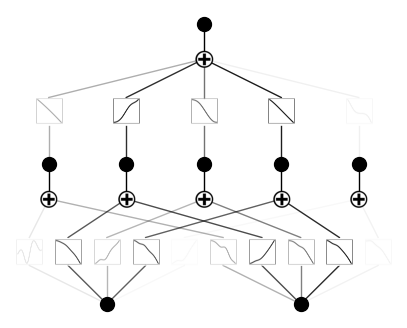

In [12]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [13]:
model.fit(dataset, opt="Adam", steps=400, lamb=0.);

| train_loss: 4.69e-02 | test_loss: 4.92e-02 | reg: 7.73e+01 | : 100%|█| 400/400 [00:04<00:00, 82.55


saving model version 0.1


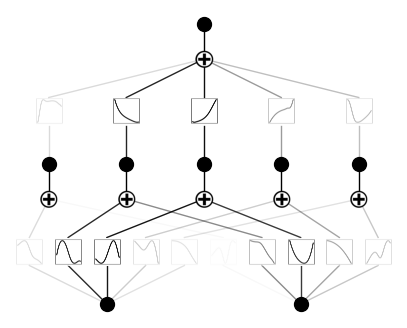

In [14]:
model.plot()

saving model version 0.2


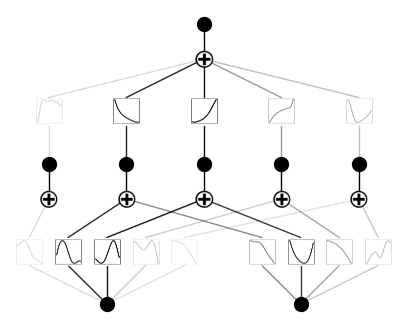

In [15]:
model = model.prune()
model.plot()

### **pytorch Adam optimizer**

In [32]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# dataset['train_input'].shape, dataset['train_label'].shape
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = dataset['train_input'].shape[0]

for epoch in range(600):
        
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{400}], Train Loss: {train_loss.item():.4f}')

Epoch [20/400], Train Loss: 0.1622
Epoch [40/400], Train Loss: 0.0383
Epoch [60/400], Train Loss: 0.0099
Epoch [80/400], Train Loss: 0.0036
Epoch [100/400], Train Loss: 0.0021
Epoch [120/400], Train Loss: 0.0015
Epoch [140/400], Train Loss: 0.0011
Epoch [160/400], Train Loss: 0.0009
Epoch [180/400], Train Loss: 0.0007
Epoch [200/400], Train Loss: 0.0006
Epoch [220/400], Train Loss: 0.0005
Epoch [240/400], Train Loss: 0.0004
Epoch [260/400], Train Loss: 0.0003
Epoch [280/400], Train Loss: 0.0003
Epoch [300/400], Train Loss: 0.0003
Epoch [320/400], Train Loss: 0.0002
Epoch [340/400], Train Loss: 0.0002
Epoch [360/400], Train Loss: 0.0002
Epoch [380/400], Train Loss: 0.0002
Epoch [400/400], Train Loss: 0.0001
Epoch [420/400], Train Loss: 0.0001
Epoch [440/400], Train Loss: 0.0001
Epoch [460/400], Train Loss: 0.0001
Epoch [480/400], Train Loss: 0.0001
Epoch [500/400], Train Loss: 0.0001
Epoch [520/400], Train Loss: 0.0001
Epoch [540/400], Train Loss: 0.0005
Epoch [560/400], Train Loss: 0.0

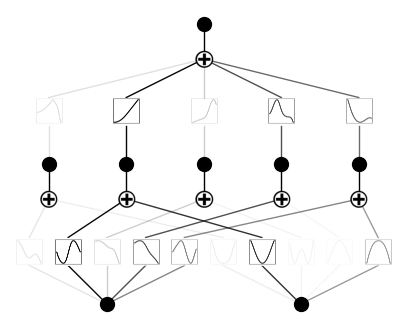

In [34]:
model.plot()

saving model version 0.1


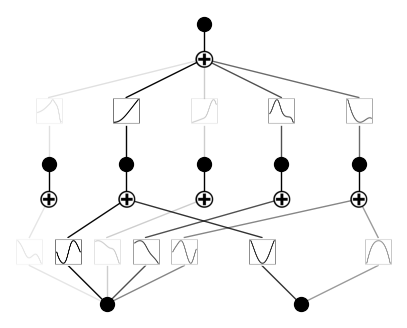

In [35]:
model = model.prune()
model.plot()

### **pykan LBFGS optimizer**

checkpoint directory created: ./model
saving model version 0.0


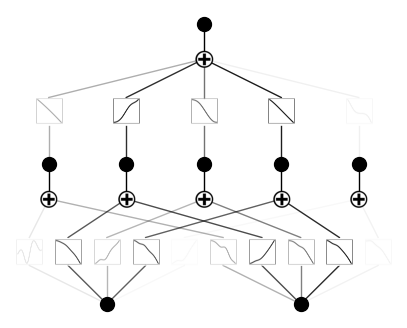

In [41]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [42]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.1);

| train_loss: 1.62e-01 | test_loss: 1.63e-01 | reg: 5.95e+00 | : 100%|█| 50/50 [00:13<00:00,  3.57it

saving model version 0.1


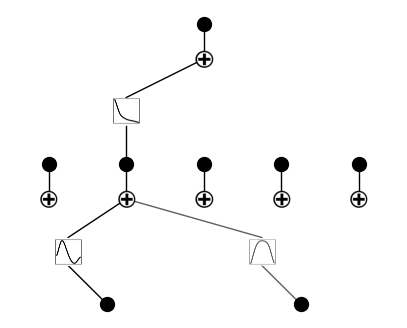

In [43]:
model.plot()

saving model version 0.2


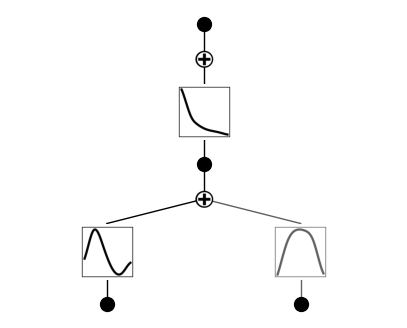

In [44]:
model = model.prune()
model.plot()

In [45]:
lib = ['1/x', 'x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.6056451797485352, c=1
fixing (0,1,0) with x^2, r2=0.9929699897766113, c=2
fixing (1,0,0) with exp, r2=0.9950411319732666, c=2
saving model version 0.3


0.4488*exp(1.7611*x_1 + 0.0169*(-8.0115*x_2 - 0.0167)**2) - 1.1553

### **pytorch LBFGS optimizer**

checkpoint directory created: ./model
saving model version 0.0


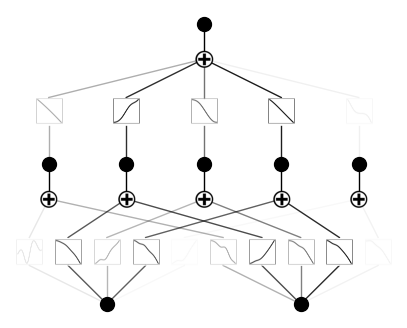

In [46]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [47]:
# dataset['train_input'].shape, dataset['train_label'].shape
optimizer = optim.LBFGS(params=model.parameters(), lr=1., history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
criterion = nn.MSELoss()

train_losses = []

batch_size = dataset['train_input'].shape[0]

old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(0.)

for epoch in range(50):
    
    if epoch == 49 and old_save_act:
        model.save_act = True
    
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    y_th=1000.
    
    def closure():
        reg_ = torch.tensor(10.)
        lamb = 0.
        
        optimizer.zero_grad()
        
        # pred = model(batch_x)
        pred = model.forward(batch_x, singularity_avoiding=False, y_th=y_th)
        
        loss = criterion(pred, batch_y)
        
        objective = loss + lamb * reg_
        # print(objective)
        objective.backward()
        return objective
    
    # Backward pass
    # optimizer.zero_grad()
    # loss.backward()
    optimizer.step(closure)
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{50}], Train Loss: {loss.item():.4f}')

Epoch [25/50], Train Loss: 0.1001
Epoch [50/50], Train Loss: 0.1001


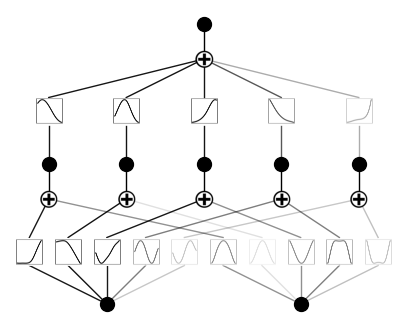

In [48]:
model.plot()

saving model version 0.1


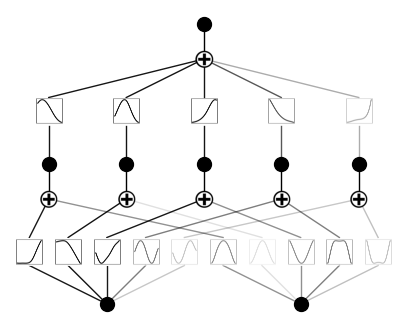

In [49]:
model = model.prune()
model.plot()

In [51]:
# model.fix_symbolic(0,0,0,'exp')
# model.fix_symbolic(0,1,0,'exp')
# model.fix_symbolic(1,0,0,'sin')
# model.fix_symbolic(2,0,0,'sin')

# **Dataset $\frac{x_0}{x_1}$ and Adam**

### **pykan Dataset $\frac{x_0}{x_1}$ and pykan Adam**

problems with big loss

In [103]:
f = lambda x: x[:,[0]] / x[:,[1]]
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [104]:
print(dataset['train_input'][0])
print("x_0/x_1 =")
print(dataset['train_label'][0])

tensor([-0.0075,  0.5547], device='cuda:0')
x_0/x_1 =
tensor([-0.0135], device='cuda:0')


In [105]:
print("min ", torch.min(dataset['train_label']))
print("max ", torch.max(dataset['train_label']))

min  tensor(-1863.1226, device='cuda:0')
max  tensor(470.1408, device='cuda:0')


checkpoint directory created: ./model
saving model version 0.0


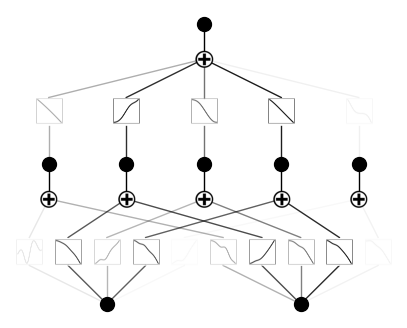

In [111]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [112]:
model.fit(dataset, opt="Adam", steps=600, lamb=0.);

| train_loss: 3.24e+01 | test_loss: 1.31e+02 | reg: 1.48e+03 | : 100%|█| 600/600 [00:09<00:00, 62.92

saving model version 0.1


saving model version 0.2


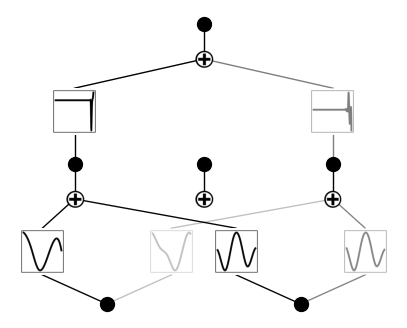

In [113]:
model = model.prune()
model.plot()

### **pykan Dataset $\frac{x_0}{x_1}$ and pytorch Adam**

problems with very big loss

checkpoint directory created: ./model
saving model version 0.0


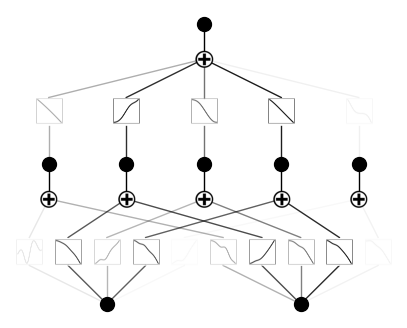

In [114]:
f = lambda x: x[:,[0]] / x[:,[1]]
dataset = create_dataset(f, n_var=2, device=device)

model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [116]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = dataset['train_input'].shape[0]

epochs = 600

for epoch in range(epochs):
        
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    # model.update_grid(dataset['train_input'][train_id])
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.5f}')

Epoch [50/600], Train Loss: 3275.85962
Epoch [100/600], Train Loss: 2735.53564
Epoch [150/600], Train Loss: 1941.17603
Epoch [200/600], Train Loss: 2856.45020
Epoch [250/600], Train Loss: 1097.37000
Epoch [300/600], Train Loss: 439.66296
Epoch [350/600], Train Loss: 6499.44824
Epoch [400/600], Train Loss: 4568.81152
Epoch [450/600], Train Loss: 3694.00220
Epoch [500/600], Train Loss: 3665.77759
Epoch [550/600], Train Loss: 3649.53760
Epoch [600/600], Train Loss: 3637.01489


saving model version 0.1


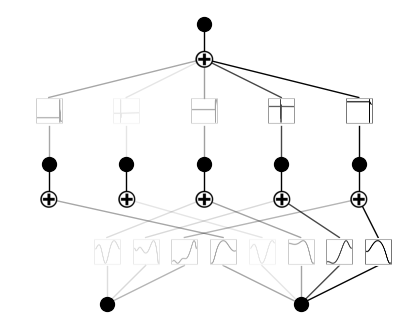

In [117]:
model = model.prune()
model.plot()

### **pytorch Dataset $\frac{x_0}{x_1}$, $x\in[0.1, 1]$ and pytorch Adam**

In [150]:
end_range = 1.0
start_range = 0.1
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = x[:, 0] / x[:, 1]
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


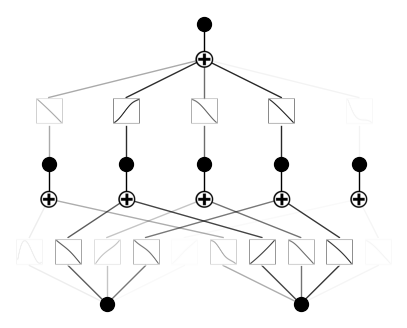

In [151]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [155]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batch_size = dataset['train_input'].shape[0]

epochs = 600

for epoch in range(epochs):
        
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    model.update_grid(dataset['train_input'][train_id])
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.5f}')

Epoch [50/600], Train Loss: 0.00056
Epoch [100/600], Train Loss: 0.00012
Epoch [150/600], Train Loss: 0.00008
Epoch [200/600], Train Loss: 0.00007
Epoch [250/600], Train Loss: 0.00005
Epoch [300/600], Train Loss: 0.00004
Epoch [350/600], Train Loss: 0.00004
Epoch [400/600], Train Loss: 0.00003
Epoch [450/600], Train Loss: 0.00003
Epoch [500/600], Train Loss: 0.00002
Epoch [550/600], Train Loss: 0.00002
Epoch [600/600], Train Loss: 0.00002


saving model version 0.3


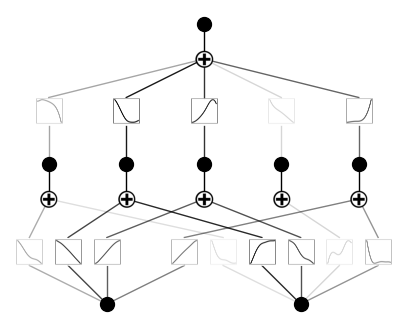

In [156]:
model = model.prune()
model.plot()

In [137]:
lib = ['1/x', 'x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.5165215730667114, c=1
fixing (0,0,1) with x, r2=0.055700644850730896, c=1
fixing (0,0,2) with x, r2=0.42689278721809387, c=1
fixing (0,0,3) with 0
fixing (0,0,4) with x, r2=0.9211500287055969, c=1
fixing (0,1,0) with x, r2=0.26008906960487366, c=1
fixing (0,1,1) with x, r2=0.1761702597141266, c=1
fixing (0,1,2) with x, r2=0.0002834964543581009, c=1
fixing (0,1,3) with 0
fixing (0,1,4) with 1/x, r2=0.991461455821991, c=2
fixing (1,0,0) with exp, r2=0.9725199937820435, c=2
fixing (1,1,0) with x, r2=0.07630479335784912, c=1
fixing (1,2,0) with exp, r2=0.9850730895996094, c=2
fixing (1,3,0) with 0
fixing (1,4,0) with x^2, r2=0.988807201385498, c=2
saving model version 0.2


In [138]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.1799*x_1 + 0.3421*x_2 + 2.1709*(-1.7813*x_1 + 0.7687 + 2.0775/(-8.364*x_2 - 0.6126))**2 + 0.2134*exp(1.8588*x_1 - 0.0454*x_2) + 0.1421*exp(2.3905*x_1 - 1.3297*x_2) - 1.8934

# **pytorch Dataset $x_0 + \frac{1}{x_1}$, $x\in[0.1, 1]$ and Adam**

start with 0.1 to avoid large values in the fraction

In [181]:
end_range = 1.0
start_range = 0.1
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = x[:, 0] + 1 / x[:, 1]
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


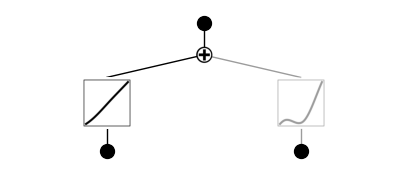

In [182]:
model = KAN(width=[2, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [183]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [184]:
batch_size = dataset['train_input'].shape[0]

epochs = 600

for epoch in range(epochs):
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    model.update_grid(dataset['train_input'][train_id])
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.5f}')

Epoch [50/600], Train Loss: 0.17282
Epoch [100/600], Train Loss: 0.04240
Epoch [150/600], Train Loss: 0.03174
Epoch [200/600], Train Loss: 0.02311
Epoch [250/600], Train Loss: 0.01562
Epoch [300/600], Train Loss: 0.00967
Epoch [350/600], Train Loss: 0.00549
Epoch [400/600], Train Loss: 0.00299
Epoch [450/600], Train Loss: 0.00175
Epoch [500/600], Train Loss: 0.00125
Epoch [550/600], Train Loss: 0.00107
Epoch [600/600], Train Loss: 0.00102


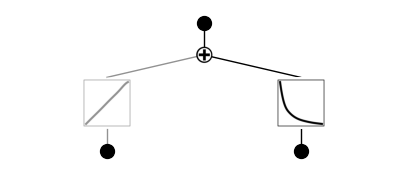

In [185]:
model.plot()

saving model version 0.1
fixing (0,0,0) with x, r2=0.9998518824577332, c=1
fixing (0,1,0) with 1/x, r2=0.9996588826179504, c=2
saving model version 0.2


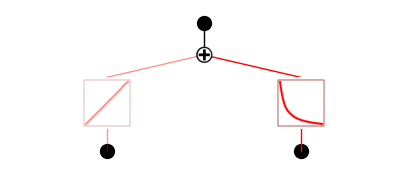

In [186]:
model = model.prune()
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
model.plot()

In [187]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

1.0002*x_1 - 0.0304 - 1.4311/(-1.3992*x_2 - 0.004)

# **pytorch Dataset $x_0 + \frac{1}{x_1}$, $x\in[0.1, 1]$ and LBFGS**

In [197]:
end_range = 1.0
start_range = 0.1
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = x[:, 0] + 1 / x[:, 1]
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


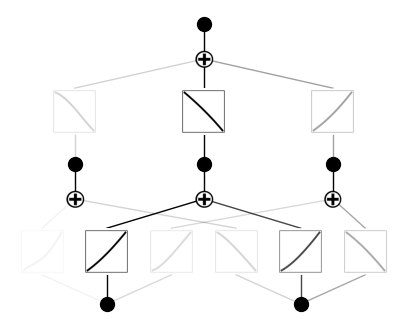

In [205]:
model = KAN(width=[2, 3, 1], grid=5, k=5, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [206]:
optimizer = optim.LBFGS(params=model.parameters(), lr=0.1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
criterion = nn.MSELoss()

In [207]:
batch_size = dataset['train_input'].shape[0]

epochs = 50

for epoch in range(epochs):
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    model.update_grid(dataset['train_input'][train_id])
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    train_loss = criterion(outputs, batch_y)
    
    def closure():
        optimizer.zero_grad()
        
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        objective = loss + 0.1
        
        objective.backward()
        return objective
    
    # Backward pass
    optimizer.step(closure=closure)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.5f}')

Epoch [10/50], Train Loss: 0.00121
Epoch [20/50], Train Loss: 0.00022
Epoch [30/50], Train Loss: 0.00007
Epoch [40/50], Train Loss: 0.00005
Epoch [50/50], Train Loss: 0.00002


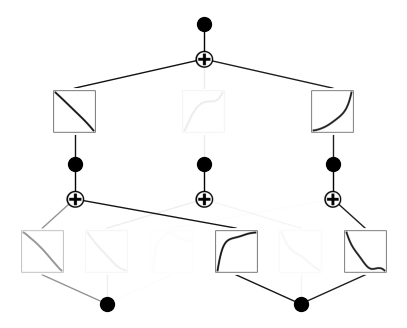

In [208]:
model.plot()

# **KAN + FC sigmoid** pytorch Adam

$\sin{2 \pi x_0} + \sin{2 \pi x_1}$, $x \in [-1.0, 1.0]$

In [77]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [78]:
class KANWithFC(nn.Module):
    def __init__(self, input_dim=2, hidden_dim1=3, output_dim=1):
        """
        Составная модель с KAN слоями и полносвязным слоем
        Args:
            input_dim: размер входа
            hidden_dim1: ширина первого KAN слоя
            hidden_dim2: ширина второго KAN слоя
            output_dim: размер выхода
        """
        super(KANWithFC, self).__init__()
        
        # Первый KAN слой: вход 2 -> выход 2
        self.kan1 = KAN(width=[input_dim, hidden_dim1], grid=5, k=3, seed=42, device=device)
        
        # Полносвязный слой с ReLU: вход 3 -> выход 1
        self.fc = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Отключаем символические вычисления для ускорения
        # self.kan1.symbolic_enabled = False
        
    def forward(self, x):
        # Проход через первый KAN
        x = self.kan1(x)
        
        # Полносвязный слой с ReLU
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x
    
    def fit_combined(self, train_input, train_label, test_input, test_label, 
                     epochs=600, lr=0.01, batch_size=32):
        """
        Обучение составной модели
        """
        # Оптимизатор для всей модели
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCELoss()
        
        train_losses = []
        test_losses = []
        
        for epoch in range(epochs):
            # Случайный батч для обучения
            # indices = torch.randperm(train_input.shape[0])[:batch_size]
            
            batches = train_input.shape[0] // batch_size
            for batch_idx in range(batches):
                if batch_idx == batches - 1:
                    indices = torch.arange(batch_idx * batch_size, train_input.shape[0])
                else:
                    indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
            
                batch_x = train_input[indices]
                batch_y = train_label[indices]
                
                # Forward pass
                outputs = self(batch_x)
                loss = criterion(outputs, batch_y)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Вычисление ошибки на тестовом наборе
            with torch.no_grad():
                test_outputs = self(test_input)
                test_loss = criterion(test_outputs, test_label)
                
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
        return train_losses, test_losses


In [79]:
model = KANWithFC(input_dim=2, hidden_dim1=1, output_dim=1)
model = model.to(device=device)

checkpoint directory created: ./model
saving model version 0.0


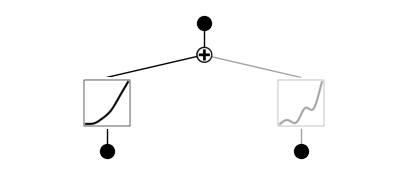

In [80]:
model.kan1(dataset['train_input'])
model.kan1.plot()

In [81]:
train_losses, test_losses = model.fit_combined(
    dataset['train_input'],
    dataset['train_label'],
    dataset['test_input'],
    dataset['test_label'],
    epochs=600,
    lr=0.01,
    batch_size=128
)

Epoch [20/600], Train Loss: 0.1601, Test Loss: 0.1803
Epoch [40/600], Train Loss: 0.0708, Test Loss: 0.0892
Epoch [60/600], Train Loss: 0.0526, Test Loss: 0.0763
Epoch [80/600], Train Loss: 0.0440, Test Loss: 0.0695
Epoch [100/600], Train Loss: 0.0382, Test Loss: 0.0648
Epoch [120/600], Train Loss: 0.0337, Test Loss: 0.0617
Epoch [140/600], Train Loss: 0.0301, Test Loss: 0.0601
Epoch [160/600], Train Loss: 0.0272, Test Loss: 0.0596
Epoch [180/600], Train Loss: 0.0249, Test Loss: 0.0598
Epoch [200/600], Train Loss: 0.0231, Test Loss: 0.0605
Epoch [220/600], Train Loss: 0.0216, Test Loss: 0.0613
Epoch [240/600], Train Loss: 0.0204, Test Loss: 0.0622
Epoch [260/600], Train Loss: 0.0195, Test Loss: 0.0632
Epoch [280/600], Train Loss: 0.0187, Test Loss: 0.0641
Epoch [300/600], Train Loss: 0.0181, Test Loss: 0.0649
Epoch [320/600], Train Loss: 0.0175, Test Loss: 0.0657
Epoch [340/600], Train Loss: 0.0171, Test Loss: 0.0665
Epoch [360/600], Train Loss: 0.0167, Test Loss: 0.0673
Epoch [380/600

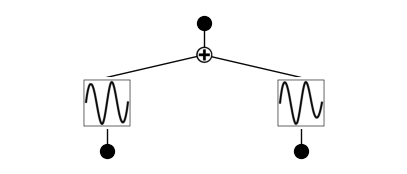

In [82]:
model.kan1.plot()

saving model version 0.1
fixing (0,0,0) with sin, r2=0.995698094367981, c=2
fixing (0,1,0) with sin, r2=0.9857227206230164, c=2
saving model version 0.2


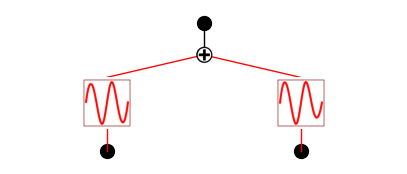

In [83]:
model.kan1 = model.kan1.prune()
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'cos', 'sin', 'abs']
model.kan1.auto_symbolic(lib=lib)
model.kan1.plot()

In [84]:
formula = model.kan1.symbolic_formula()[0][0]
ex_round(formula, 4)

-6.1728*sin(6.2911*x_1 - 9.4065) + 5.9339*sin(6.2604*x_2 - 0.0041) - 2.8882

In [85]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kan1.act_fun.0.coef tensor([[[-5.7765,  0.8727,  0.8964, -2.5617,  2.1104, -1.4840, -1.2874,
           5.1690]],

        [[-7.2256,  1.1066,  0.9019, -2.7772,  2.1816, -1.4197, -0.9354,
           3.5419]]], device='cuda:0')
kan1.act_fun.0.scale_base tensor([[0.4737],
        [0.0010]], device='cuda:0')
kan1.act_fun.0.scale_sp tensor([[6.4368],
        [6.1134]], device='cuda:0')
kan1.symbolic_fun.0.affine tensor([[[-6.2911e+00,  9.4065e+00,  6.1728e+00, -1.5474e+00],
         [-6.2604e+00,  4.0800e-03, -5.9339e+00, -1.3408e+00]]],
       device='cuda:0')
fc.weight tensor([[7.4966]], device='cuda:0')
fc.bias tensor([-0.4902], device='cuda:0')


# **KAN + FC sigmoid** pytorch LBFGS

$\sin{2 \pi x_0} + \sin{2 \pi x_1}$, $x \in [-1.0, 1.0]$

In [86]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [119]:
class KANWithFC(nn.Module):
    def __init__(self, input_dim=2, hidden_dim1=3, output_dim=1):
        """
        Составная модель с KAN слоями и полносвязным слоем
        Args:
            input_dim: размер входа
            hidden_dim1: ширина первого KAN слоя
            hidden_dim2: ширина второго KAN слоя
            output_dim: размер выхода
        """
        super(KANWithFC, self).__init__()
        
        # Первый KAN слой: вход 2 -> выход 2
        self.kan1 = KAN(width=[input_dim, hidden_dim1], grid=5, k=3, seed=42, device=device)
        
        # Полносвязный слой с ReLU: вход 3 -> выход 1
        self.fc = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Отключаем символические вычисления для ускорения
        # self.kan1.symbolic_enabled = False
        
    def forward(self, x):
        # Проход через первый KAN
        x = self.kan1(x)
        
        # Полносвязный слой с ReLU
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x
    
    def fit_combined(self, train_input, train_label, test_input, test_label, 
                     epochs=600, lr=0.01, batch_size=32):
        """
        Обучение составной модели
        """
        # Оптимизатор для всей модели
        # optimizer = optim.Adam(self.parameters(), lr=lr)
        optimizer = optim.LBFGS(params=self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
        # criterion = nn.MSELoss()
        criterion = nn.BCELoss()
        
        train_losses = []
        test_losses = []
        
        for epoch in range(epochs):
            # Случайный батч для обучения
            # indices = torch.randperm(train_input.shape[0])[:batch_size]
            
            batches = train_input.shape[0] // batch_size
            for batch_idx in range(batches):
                if batch_idx == batches - 1:
                    indices = torch.arange(batch_idx * batch_size, train_input.shape[0])
                else:
                    indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
            
                batch_x = train_input[indices]
                batch_y = train_label[indices]
                
                # Forward pass
                outputs = self(batch_x)
                train_loss = criterion(outputs, batch_y)
                
                def closure():
                    optimizer.zero_grad()
                    
                    pred = self(batch_x)
                    loss = criterion(pred, batch_y)
                    objective = loss
                    
                    objective.backward()
                    return objective
                
                # Backward pass
                optimizer.step(closure=closure)
                
                # Backward pass
                # optimizer.zero_grad()
                # loss.backward()
                # optimizer.step()
            
            # Вычисление ошибки на тестовом наборе
            with torch.no_grad():
                test_outputs = self(test_input)
                test_loss = criterion(test_outputs, test_label)
                
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
        return train_losses, test_losses


In [131]:
model = KANWithFC(input_dim=2, hidden_dim1=1, output_dim=1)
model = model.to(device=device)

checkpoint directory created: ./model
saving model version 0.0


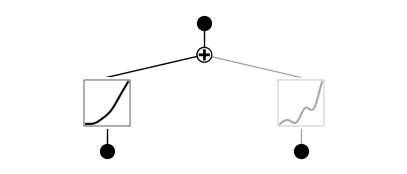

In [132]:
model.kan1(dataset['train_input'])
model.kan1.plot()

In [133]:
train_losses, test_losses = model.fit_combined(
    dataset['train_input'],
    dataset['train_label'],
    dataset['test_input'],
    dataset['test_label'],
    epochs=50,
    lr=0.01,
    batch_size=1000
)

Epoch [10/50], Train Loss: 0.0765, Test Loss: 0.0461
Epoch [20/50], Train Loss: 0.0505, Test Loss: 0.0302
Epoch [30/50], Train Loss: 0.0445, Test Loss: 0.0221
Epoch [40/50], Train Loss: 0.0420, Test Loss: 0.0236
Epoch [50/50], Train Loss: 0.0420, Test Loss: 0.0236


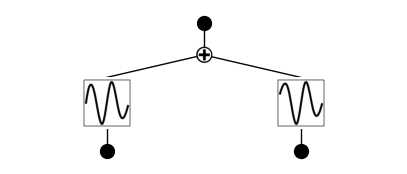

In [134]:
model.kan1.plot()

saving model version 0.1
fixing (0,0,0) with cos, r2=0.9870084524154663, c=2
fixing (0,1,0) with sin, r2=0.9677913784980774, c=2
saving model version 0.2


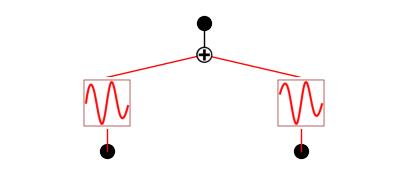

In [135]:
model.kan1 = model.kan1.prune()
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'cos', 'sin', 'abs']
model.kan1.auto_symbolic(lib=lib)
model.kan1.plot()

In [137]:
formula = model.kan1.symbolic_formula()[0][0]
ex_round(formula, 4)

-639.4829*sin(6.1906*x_2 + 9.4108) + 629.2889*cos(6.3251*x_1 - 1.5866) + 250.6734

In [138]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kan1.act_fun.0.coef tensor([[[-94.0919,  20.8118,  26.9053, -36.7304,  47.6151, -16.4904,  -1.0408,
           39.8412]],

        [[-33.1062,  13.7096,  29.7831, -55.4302,  51.3477, -25.5072,  -7.8414,
           45.7626]]], device='cuda:0')
kan1.act_fun.0.scale_base tensor([[-20.5556],
        [-20.2655]], device='cuda:0')
kan1.act_fun.0.scale_sp tensor([[39.3699],
        [32.0707]], device='cuda:0')
kan1.symbolic_fun.0.affine tensor([[[ -6.3251,   1.5866, 629.2889, 226.6335],
         [ -6.1906,  -9.4108, 639.4829,  24.0398]]], device='cuda:0')
fc.weight tensor([[0.0611]], device='cuda:0')
fc.bias tensor([-33.8938], device='cuda:0')


# **KAN + FC sigmoid** pytorch Adam + LBFGS

without regularization Adam is better

$\sin{2 \pi x_0} + \sin{2 \pi x_1}$, $x \in [-1.0, 1.0]$

In [139]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [168]:
class KANWithFC(nn.Module):
    def __init__(self, input_dim=2, hidden_dim1=3, output_dim=1):
        """
        Составная модель с KAN слоями и полносвязным слоем
        Args:
            input_dim: размер входа
            hidden_dim1: ширина первого KAN слоя
            hidden_dim2: ширина второго KAN слоя
            output_dim: размер выхода
        """
        super(KANWithFC, self).__init__()
        
        # Первый KAN слой: вход 2 -> выход 2
        self.kan1 = KAN(width=[input_dim, hidden_dim1], grid=5, k=3, seed=42, device=device)
        
        # Полносвязный слой с ReLU: вход 3 -> выход 1
        self.fc = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Отключаем символические вычисления для ускорения
        # self.kan1.symbolic_enabled = False
        
    def forward(self, x):
        # Проход через первый KAN
        x = self.kan1(x)
        
        # Полносвязный слой с ReLU
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x
    
    def fit_combined(self, train_input, train_label, test_input, test_label, 
                     epochs_adam=600, lr_adam=0.01, batch_size_adam=32,
                     epochs_lbfgs=50, lr_lbfgs=0.01, batch_size_lbfgs=32):
        """
        Обучение составной модели
        """
        # Оптимизатор для всей модели
        optimizer_adam = optim.Adam(params=self.parameters(), lr=lr_adam)
        optimizer_lbfgs = optim.LBFGS(params=self.parameters(), lr=lr_lbfgs, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
        
        # criterion = nn.MSELoss()
        criterion = nn.BCELoss()
        
        train_losses = []
        test_losses = []
        
        for epoch in range(epochs_adam):
            batches = train_input.shape[0] // batch_size_adam
            for batch_idx in range(batches):
                if batch_idx == batches - 1:
                    indices = torch.arange(batch_idx * batch_size_adam, train_input.shape[0])
                else:
                    indices = torch.arange(batch_idx * batch_size_adam, (batch_idx + 1) * batch_size_adam)
            
                batch_x = train_input[indices]
                batch_y = train_label[indices]
                
                # Forward pass
                outputs = self(batch_x)
                loss = criterion(outputs, batch_y) + 0.1
                
                # Backward pass
                optimizer_adam.zero_grad()
                loss.backward()
                optimizer_adam.step()
            
            # Вычисление ошибки на тестовом наборе
            with torch.no_grad():
                test_outputs = self(test_input)
                test_loss = criterion(test_outputs, test_label)
                
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            
            if (epoch + 1) % 10 == 0:
                print(f'Adam Epoch [{epoch+1}/{epochs_adam}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
                
        
        for epoch in range(epochs_lbfgs):
            batches = train_input.shape[0] // batch_size_lbfgs
            for batch_idx in range(batches):
                if batch_idx == batches - 1:
                    indices = torch.arange(batch_idx * batch_size_lbfgs, train_input.shape[0])
                else:
                    indices = torch.arange(batch_idx * batch_size_lbfgs, (batch_idx + 1) * batch_size_lbfgs)
            
                batch_x = train_input[indices]
                batch_y = train_label[indices]
                
                # Forward pass
                outputs = self(batch_x)
                train_loss = criterion(outputs, batch_y)
                
                def closure():
                    optimizer_lbfgs.zero_grad()
                    
                    pred = self(batch_x)
                    loss = criterion(pred, batch_y) + 0.1
                    objective = loss
                    
                    objective.backward()
                    return objective
                
                optimizer_lbfgs.step(closure=closure)
            
            # Вычисление ошибки на тестовом наборе
            with torch.no_grad():
                test_outputs = self(test_input)
                test_loss = criterion(test_outputs, test_label)
                
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
            if (epoch + 1) % 10 == 0:
                print(f'LBFGS Epoch [{epoch+1}/{epochs_lbfgs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
        return train_losses, test_losses


In [169]:
model = KANWithFC(input_dim=2, hidden_dim1=1, output_dim=1)
model = model.to(device=device)

checkpoint directory created: ./model
saving model version 0.0


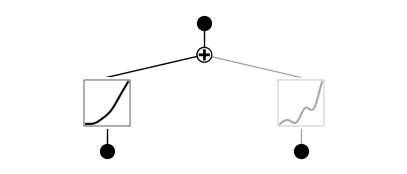

In [170]:
model.kan1(dataset['train_input'])
model.kan1.plot()

In [ ]:
train_losses, test_losses = model.fit_combined(
    dataset['train_input'],
    dataset['train_label'],
    dataset['test_input'],
    dataset['test_label'],
    epochs_adam=300,
    lr_adam=0.01,
    batch_size_adam=32,
    epochs_lbfgs=50,
    lr_lbfgs=0.1,
    batch_size_lbfgs=512,
)

Adam Epoch [10/300], Train Loss: 0.1447, Test Loss: 0.0494
Adam Epoch [20/300], Train Loss: 0.1420, Test Loss: 0.0468
Adam Epoch [30/300], Train Loss: 0.1423, Test Loss: 0.0455
Adam Epoch [40/300], Train Loss: 0.1428, Test Loss: 0.0463
Adam Epoch [50/300], Train Loss: 0.1434, Test Loss: 0.0492
Adam Epoch [60/300], Train Loss: 0.1429, Test Loss: 0.0524
Adam Epoch [70/300], Train Loss: 0.1405, Test Loss: 0.0544
Adam Epoch [80/300], Train Loss: 0.1366, Test Loss: 0.0551
Adam Epoch [90/300], Train Loss: 0.1324, Test Loss: 0.0559
Adam Epoch [100/300], Train Loss: 0.1291, Test Loss: 0.0571
Adam Epoch [110/300], Train Loss: 0.1265, Test Loss: 0.0582
Adam Epoch [120/300], Train Loss: 0.1248, Test Loss: 0.0589
Adam Epoch [130/300], Train Loss: 0.1238, Test Loss: 0.0594
Adam Epoch [140/300], Train Loss: 0.1234, Test Loss: 0.0596
Adam Epoch [150/300], Train Loss: 0.1233, Test Loss: 0.0597
Adam Epoch [160/300], Train Loss: 0.1233, Test Loss: 0.0597
Adam Epoch [170/300], Train Loss: 0.1233, Test Lo

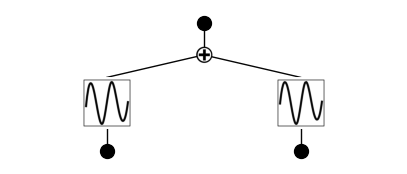

In [172]:
model.kan1.plot()

saving model version 0.1
fixing (0,0,0) with sin, r2=0.9943762421607971, c=2
fixing (0,1,0) with cos, r2=0.992611289024353, c=2
saving model version 0.2


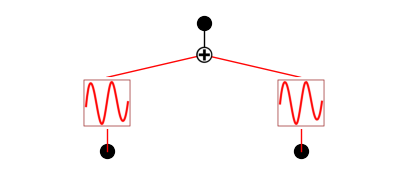

In [173]:
model.kan1 = model.kan1.prune()
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'cos', 'sin', 'abs']
model.kan1.auto_symbolic(lib=lib)
model.kan1.plot()

In [174]:
formula = model.kan1.symbolic_formula()[0][0]
ex_round(formula, 4)

-34.4886*sin(6.3154*x_1 + 9.4126) + 34.4498*cos(6.2776*x_2 - 1.5827) - 17.3427

In [161]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kan1.act_fun.0.coef tensor([[[-36.5309,   4.1460,   3.0593, -10.7284,   8.2578,  -5.7360,  -5.1720,
           20.4713]],

        [[-32.0557,   4.8880,   4.3516, -12.2789,  10.0367,  -5.7958,  -5.0426,
           24.2483]]], device='cuda:0')
kan1.act_fun.0.scale_base tensor([[-0.9291],
        [-3.7502]], device='cuda:0')
kan1.act_fun.0.scale_sp tensor([[8.8930],
        [7.6077]], device='cuda:0')
kan1.symbolic_fun.0.affine tensor([[[ -6.3152,  -9.4126,  34.4467, -10.9162],
         [ -6.2778,  -9.4130,  34.4054,  -6.3958]]], device='cuda:0')
fc.weight tensor([[1.4104]], device='cuda:0')
fc.bias tensor([0.3374], device='cuda:0')
